In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..', 'wlcstat-master')))

import wlcstat.chromo

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..', 'stochastic-gene-conf-master')))

from stochastic_gene_conf import gene_conf
from stochastic_gene_conf import gene_analysis

figure_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'subfigures/'))
data_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'data/'))

import numpy as np
import numpy.matlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import pickle
from scipy import sparse

In [2]:
gene_name = "MODEL10K"
exp_name = "NULL"

files = os.listdir(os.path.join(data_path,gene_name,exp_name))

with open(os.path.join(data_path,gene_name,exp_name,'variables.pkl'), 'rb') as file:
    temp = pickle.load(file)
    location = temp[0]
    signal = temp[1]
    Gene_start = temp[2]
    Gene_end = temp[3]
    TSS_vec = temp[4]
    accessible_starts = temp[5]
    accessible_ends = temp[6]
    cdf = temp[7]
    half_wrap = temp[8]
    
N_files = 5000

if N_files >= len(files):
    N_files = int(len(files))-1

tss_contact_mat = np.zeros([len(location)-1,61])
packed_link_array = np.zeros(N_files)
khun_array = np.zeros(61)
rog_array = np.zeros(61)
packed_link_N = np.zeros(61)

for i in range(N_files):

    strtemp = files[i]
    if strtemp[0] != 'v':
        with open(os.path.join(data_path,gene_name,exp_name,strtemp), 'rb') as file:
            [tss_contact_temp,rog_mean,r2_mean,packed_link]  = pickle.load(file)
            tss_contact_temp = np.array(sparse.csc_matrix.todense(tss_contact_temp[0]))[0]

            tss_contact_mat[:,packed_link-30] = tss_contact_mat[:,packed_link-30] + tss_contact_temp
            packed_link_array[i] = packed_link
            khun_array[packed_link-30] = khun_array[packed_link-30] + r2_mean/(Gene_end-Gene_start)
            rog_array[packed_link-30] = rog_array[packed_link-30] + rog_mean
            packed_link_N[packed_link-30] += 1
            
for j in range(len(packed_link_N)):
    tss_contact_mat[:,j] = tss_contact_mat[:,j]/packed_link_N[j]
    khun_array[j] = khun_array[j]/packed_link_N[j]
    rog_array[j] = rog_array[j]/packed_link_N[j]

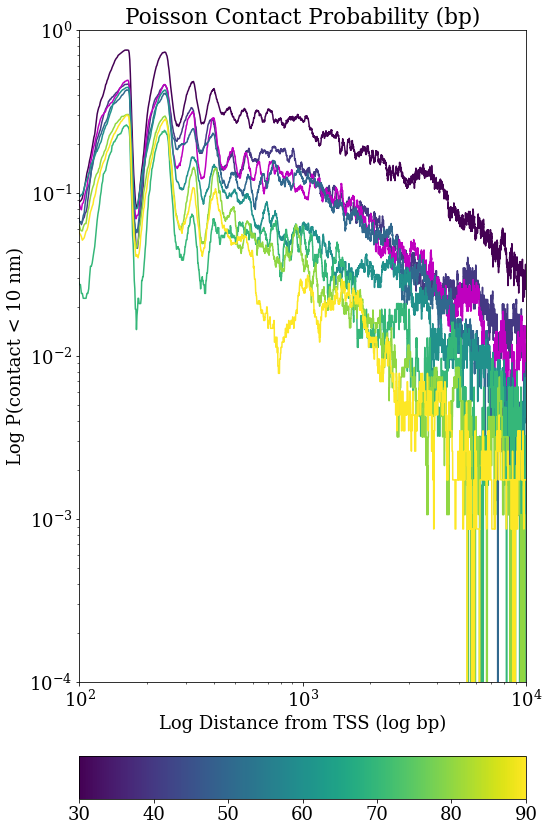

In [3]:
links = np.arange(30,91,1).astype(int)
sigs = np.array([0,10]).astype(int)

plt.figure(figsize=(8,12))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 18}
plt.rc('font', **font)

c = iter(plt.cm.viridis(np.linspace(0,1,len(links))))
for ix in range(len(links)):
    alpha = next(c)
    if np.mod(links[ix],10)==0:
        plt.plot(location[0:-1],tss_contact_mat[:,ix],'-',color=alpha)
    if links[ix] == 42:
        plt.plot(location[0:-1],tss_contact_mat[:,ix],'m-')

plt.xlim([1e2,1e4])
plt.ylim([1e-4,1e0])
plt.yscale('log')
plt.xscale('log')

plt.title("Poisson Contact Probability (bp)")
plt.xlabel('Log Distance from TSS (log bp)')
plt.ylabel('Log P(contact < 10 nm)')

cax = plt.axes([0.125, -0.01, 0.775, 0.05])
cmappable = ScalarMappable(Normalize(30,90),cmap='viridis')
plt.colorbar(cmappable,cax=cax,orientation='horizontal')

# plt.tight_layout()
plt.draw()
plt.savefig(os.path.join(figure_path, r"pcontact_curves.pdf"), transparent=True)
plt.show()

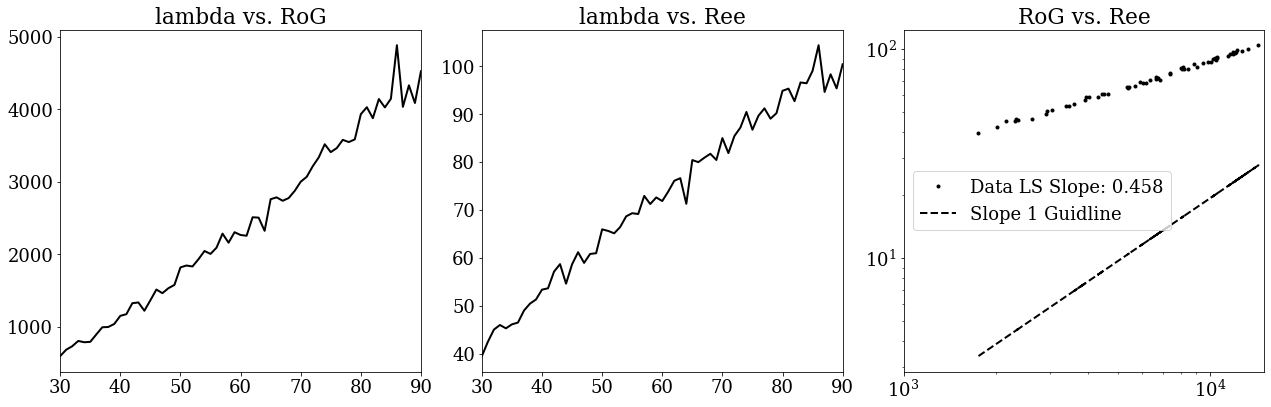

In [4]:
L0 = Gene_end-Gene_start

plt.figure(figsize=(18,6))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 18}
plt.rc('font', **font)

plt.subplot(1,3,1)
plt.plot(links,0.34*rog_array,'k-',linewidth=2)
plt.xlim([30,90])
plt.title('lambda vs. RoG')

plt.subplot(1,3,2)
plt.plot(links,0.34*np.sqrt(khun_array*L0),'k-',linewidth=2)
plt.xlim([30,90])
plt.title('lambda vs. Ree')


x = np.log10(rog_array)
y = np.log10(np.sqrt(khun_array*L0))

A = np.vstack([x, np.ones(len(x))]).T

m, c = np.linalg.lstsq(A, y, rcond=None)[0]

plt.subplot(1,3,3)
plt.plot(rog_array,0.34*np.sqrt(khun_array*L0),'k.',label = 'Data LS Slope: '+str(np.round(m,3)),linewidth=2)
plt.plot(rog_array,0.34*10*rog_array/rog_array[0],'k--',label='Slope 1 Guidline',linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.xlim([1e3,1.5e4])
plt.title('RoG vs. Ree')
plt.legend()

plt.tight_layout()
plt.draw()
plt.savefig(os.path.join(figure_path, r"poisson_rog_ree.pdf"), transparent=True)
plt.show()